In [1]:
import sys
sys.path.append('/home/npopkov/dll24')

import h5py
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
torch.set_float32_matmul_precision('medium')

class LatentDataset(Dataset):
    def __init__(self, h5_file):
        self.shape = np.array(h5_file[list(h5_file.keys())[0]]).shape
        self.data = self.createData(h5_file)
        self.min = self.data.min()
        self.max = self.data.max()
        self.std = self.data.std()
        self.mean = self.data.mean()
        self.transform('normalize')


    def createData(self, h5_file):
        data = []
        for key in h5_file.keys():
        
            sample = np.array(h5_file[key])

            data.append(np.array(sample))
        
        return torch.tensor(np.array(data)).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    def transform(self, type: str = 'normalize'):
        if type == 'standardize':
            self.data = (self.data - self.mean) / self.std
        elif type == 'normalize':
            self.data = (self.data - self.min) / (self.max - self.min)
        else:
            raise ValueError('Unknown transformation type')
        
    def inverse_transform(self, data):

        return data * (self.max - self.min) + self.min
    
    def unflatten(self, data):
        return data.reshape(self.shape)
    

hdf = h5py.File('ENC8X255.hdf5', 'r')
dataset = LatentDataset(hdf)
hdf.close()

In [2]:
dataset.data.shape

torch.Size([5756, 8, 255])

In [3]:
from models.ddpm.DDPMBase import DDPMBase
from models.ddpm.CAUnet import CAUnet
from models.ddpm.oneDCAUnet import oneDCAUnet


n_steps, betaMin, betaMax = 1000, 10**-6, 0.002

network = CAUnet(n_steps=n_steps,
                 c_in=8,
                 c_out=8,).to('cuda')

model = DDPMBase(network=network,
                betaMin=betaMin,
                betaMax=betaMax,
                n_steps=n_steps).to('cuda')


/home/npopkov/dll24/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# from audio_diffusion_pytorch import DiffusionModel, UNetV0, VDiffusion, VSampler
# fac = 1
# diffusion = DiffusionModel(
#     net_t=UNetV0, # The model type used for diffusion (U-Net V0 in this case)
#     in_channels=16, # U-Net: number of input/output (audio) channels
#     channels=[fac*8, fac*32, fac*64, fac*128, fac*256, fac*512, fac*512, fac*1024, fac*1024], # U-Net: channels at each layer
#     factors=[1, 4, 4, 4, 2, 2, 2, 2, 2], # U-Net: downsampling and upsampling factors at each layer
#     items=[1, 2, 2, 2, 2, 2, 2, 4, 4], # U-Net: number of repeating items at each layer
#     attentions=[1,1,1, 1, 1, 1, 1, 1, 1], # U-Net: attention enabled/disabled at each layer
#     attention_heads=16, # U-Net: number of attention heads per attention item
#     attention_features=64, # U-Net: number of attention features per attention item
#     diffusion_t=VDiffusion, # The diffusion method used
#     sampler_t=VSampler, # The diffusion sampler used
# )

In [5]:
import lightning as lt

class Lightningwrapper(lt.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        batch = batch
        loss = self.model(batch)
        self.log('train_loss', loss)
        return loss
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=3e-4)

#lt_model = Lightningwrapper(diffusion)
dataloader = DataLoader(dataset, batch_size=32,num_workers=30,shuffle=True,)
# Train model with audio waveforms
trainer = lt.Trainer(max_epochs=100)
trainer.fit(model, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | network | CAUnet | 427 K  | train
-------------------------------------------
427 K     Trainable params
0         Non-trainable params
427 K     Total params
1.709     Total estimated model params size (MB)
197       Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 180/180 [00:02<00:00, 65.56it/s, v_num=29]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 180/180 [00:02<00:00, 64.77it/s, v_num=29]


In [12]:
# after a lot of training
def sample(diffu, batch_size,shape):
        diffu.to('cuda')  
        x = torch.randn(batch_size, *shape).to('cuda')
        
        for i in range(n_steps-1,0,-1):
            t = torch.tensor([i]).to('cuda')
            x = diffu.subtractNoise(x,t ,None,None)
        return x
with torch.no_grad():
    sampled_images = sample(model,batch_size=4,shape=dataset.data.shape[1:])
sampled_images = dataset.inverse_transform(sampled_images)

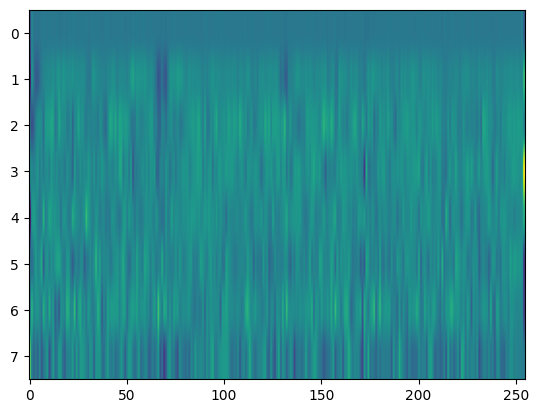

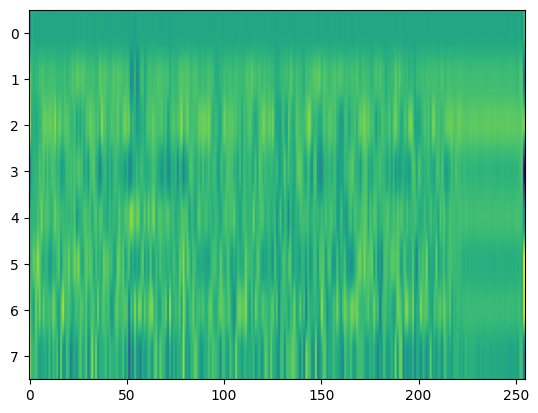

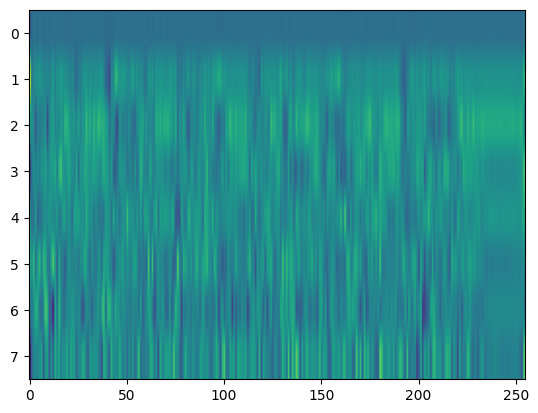

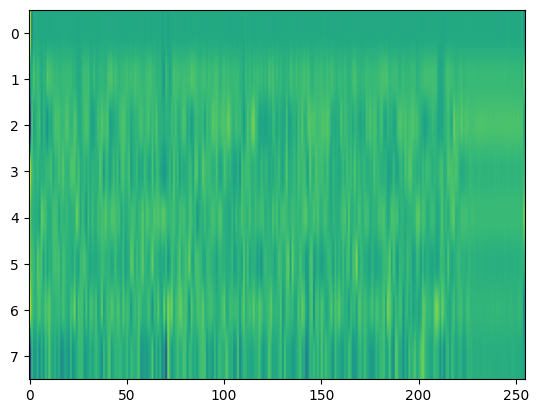

In [13]:
for i in range(4):
    plt.imshow(sampled_images[i].int().detach().cpu().numpy(),aspect='auto')
    plt.show()

In [7]:
init  = torch.randn(4,8,255).to('cuda')
t = torch.tensor([17]).repeat([4]).to('cuda')

pred = model.predictNoise(init,t,None,None)
print(pred.shape)

torch.Size([4, 8, 255])


In [20]:
from encodec import EncodecModel
from encodec.utils import convert_audio

import dac
from audiotools import AudioSignal
import torchaudio
import torch

# Instantiate a pretrained EnCodec model
model = EncodecModel.encodec_model_24khz()
model.set_target_bandwidth(6.0)

/home/npopkov/dll24/.conda/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [25]:
input = [(sampled_images[0].int().unsqueeze(0).detach().cpu(),None)]
print(input)
decoded = model.decode(input)

[(tensor([[[ -529,   285,    42,  ...,    58,   267,  -253],
         [-1103,   514,    40,  ...,   308,   279,   987],
         [   77,  -457,  -194,  ...,   546,   558,   211],
         ...,
         [  105,   -32,   194,  ...,   511,   467,  -656],
         [  -14,   892,   314,  ...,   292,   336,  -587],
         [ 1390,   218,  -137,  ...,   223,   156,   156]]], dtype=torch.int32), None)]


IndexError: index out of range in self

: 